In [1]:
import pandas as pd
import seaborn as sns
import rdkit
import torch
import vina
import meeko
import pexpect
import pickle
import numpy as np
from scipy.stats import norm
from typing import Optional, Union, List
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.domain_reduction import DomainTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.target_space import TargetSpace
import dimorphite_dl
import sys
from contextlib import redirect_stdout
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
knowndrugs = {
              "Gilteritinib":r"CCc1nc(C(=O)N)c(Nc2ccc(N3CCC(CC3)N4CCN(C)CC4)c(OC)c2)nc1NC5CCOCC5", 
              "Quizartinib":r"CC(C)(C)c1cc(no1)NC(=O)Nc2ccc(cc2)c3cn4c5ccc(cc5sc4n3)OCCN6CCOCC6", 
              "Crenolanib":r"O(c5cc4ncn(c1nc3c(cc1)cccc3N2CCC(N)CC2)c4cc5)CC6(COC6)C",
              "Tandutinib":r"CC(C)OC1=CC=C(C=C1)NC(=O)N2CCN(CC2)C3=NC=NC4=CC(=C(C=C43)OC)OCCCN5CCCCC5",
              "Sorafenib":r"CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)C(F)(F)F)Cl",
              "Sunitinib":r"CCN(CC)CCNC(=O)c1c(c([nH]c1C)/C=C\2/c3cc(ccc3NC2=O)F)C",
              "Lestaurtinib":r"C[C@@]12[C@](C[C@@H](O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)(CO)O",
              "Midostaurin":r"C[C@@]12[C@@H]([C@@H](C[C@@H](O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)N(C)C(=O)C9=CC=CC=C9)OC",
              "Ponatinib":r"Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)CN5CCN(CC5)C"
              }
knownaffins = {
              "Gilteritinib":-7.71, 
              "Quizartinib":-7.63, 
              "Crenolanib":-8.28,
              "Tandutinib":-7.07,
              "Sorafenib":-7.66,
              "Sunitinib":-7.53,
              "Lestaurtinib":-8.10,
              "Midostaurin":-8.88,
              "Ponatinib":-7.83
              }

In [50]:
from rdkit.Chem import rdFreeSASA
def max_affin(drug):
    mol = rdkit.Chem.MolFromSmiles(drug)
    mol = rdkit.Chem.AddHs(mol)
    rdkit.Chem.AllChem.EmbedMolecule(mol)
    
    def classifyAtoms(mol, polar_atoms={1, 7,8,9,15,16,17}):
	#Taken from https://github.com/mittinatten/freesasa/blob/master/src/classifier.c
    #H originally 1.10 but vinardo ignores so changed to zero
        symbol_radius = {"H": 0.0, "C": 1.70, "N": 1.55, "O": 1.52, "P": 1.80, "S": 1.80, "SE": 1.90,
        "F": 1.47, "CL": 1.75, "BR": 1.83, "I": 1.98,
        "LI": 1.81, "BE": 1.53, "B": 1.92,
        "NA": 2.27, "MG": 1.74, "AL": 1.84, "SI": 2.10,
        "K": 2.75, "CA": 2.31, "GA": 1.87, "GE": 2.11, "AS": 1.85,
        "RB": 3.03, "SR": 2.49, "IN": 1.93, "SN": 2.17, "SB": 2.06, "TE": 2.06}
        hbd = rdkit.Chem.MolFromSmarts('[#7H,#7H2,#7H3,#8H]')
        hbds = mol.GetSubstructMatches(hbd)
        hba = rdkit.Chem.MolFromSmarts('[#7X1,#7X2,#7X3,#8,#9,#17,#16]') 
        hbas = mol.GetSubstructMatches(hba)

        hphobe_interactions = 0
        hbond_interactions = 0
        gauss_interactions = 0
        radii = [] 

        for atom in mol.GetAtoms():
            radii.append(symbol_radius[atom.GetSymbol().upper()])
        opts = rdFreeSASA.SASAOpts()
        opts.probeRadius = 0.0
        rdFreeSASA.CalcSASA(mol,radii,opts=opts)

        for atom in mol.GetAtoms():
            radius = symbol_radius[atom.GetSymbol().upper()]
            if radius == 0:
                continue
            area = (np.pi*radius**2)
            idx = atom.GetIdx()
            SASA = float(atom.GetProp("SASA"))
            if (idx,) in hbds or (idx,) in hbas:
                hbond_interactions+=SASA/max(area,np.pi*1.55**2)

            if atom.GetAtomicNum() not in polar_atoms:
                hphobe_interactions += SASA/max(area,np.pi*1.55**2)

            gauss_interactions += SASA/max(area,np.pi*1.55**2)
        
        return hphobe_interactions,hbond_interactions,gauss_interactions
    
    hphobe_interactions,hbond_interactions,gauss_interactions = classifyAtoms(mol)  

    
    gauss_en = -0.045*gauss_interactions
    hbond_en = -0.6*hbond_interactions
    hydrophob_en = -0.035*hphobe_interactions  
    
    max_score = hbond_en+gauss_en+hydrophob_en
    print(f"max: {max_score:.2f}, hbonds: {hbond_en:.1f}, gauss: {gauss_en:.2f}, hydrophob: {hydrophob_en:.2f}")
    return max_score
    

    

In [59]:
for drug in knowndrugs:
    max_score = max_affin(knowndrugs[drug])
    print(knownaffins[drug],max_score-knownaffins[drug])

max: -12.26, hbonds: -8.2, gauss: -2.56, hydrophob: -1.52
-7.71 -4.554977571524771
max: -12.97, hbonds: -9.0, gauss: -2.53, hydrophob: -1.44
-7.63 -5.342989904588795
max: -8.65, hbonds: -5.3, gauss: -2.03, hydrophob: -1.27
-8.28 -0.3651961297918138
max: -11.11, hbonds: -6.8, gauss: -2.65, hydrophob: -1.67
-7.07 -4.042113373153967
max: -15.23, hbonds: -12.2, gauss: -2.09, hydrophob: -0.92
-7.66 -7.571852011123417
max: -9.83, hbonds: -6.8, gauss: -1.93, hydrophob: -1.10
-7.53 -2.2982037432803386
max: -9.26, hbonds: -6.4, gauss: -1.82, hydrophob: -1.04
-8.1 -1.1567458187869608
max: -9.21, hbonds: -5.3, gauss: -2.39, hydrophob: -1.55
-8.88 -0.3300690844216856
max: -12.54, hbonds: -8.7, gauss: -2.43, hydrophob: -1.38
-7.83 -4.709465203603267


In [51]:
data = pickle.load(open("200pred_list_prob03.pk1","rb"))
diffs = {}
for entry in data:
    if entry[0]!="failed":
        try:
            max_score=max_affin(entry[0])
            diff = max_score-min(entry[2])
            diffs[entry[0]]=diff
            print(f"best poss: {max_score:.2f}, best observed: {min(entry[2]):.2f}, diff: {diff:.2f}")
        except:
            print("failed")

max: -8.78, hbonds: -6.4, gauss: -1.54, hydrophob: -0.83
best poss: -8.78, best observed: -5.93, diff: -2.85
max: -10.73, hbonds: -7.8, gauss: -1.93, hydrophob: -1.05
best poss: -10.73, best observed: -6.73, diff: -4.00
max: -9.34, hbonds: -5.9, gauss: -2.11, hydrophob: -1.29
best poss: -9.34, best observed: -6.90, diff: -2.44
max: -8.58, hbonds: -5.5, gauss: -1.89, hydrophob: -1.15
best poss: -8.58, best observed: -6.45, diff: -2.13
max: -8.51, hbonds: -5.8, gauss: -1.74, hydrophob: -1.02
best poss: -8.51, best observed: -8.22, diff: -0.29
max: -7.75, hbonds: -5.4, gauss: -1.52, hydrophob: -0.87
best poss: -7.75, best observed: -6.98, diff: -0.77
max: -9.58, hbonds: -7.6, gauss: -1.35, hydrophob: -0.60
best poss: -9.58, best observed: -5.73, diff: -3.85
max: -6.56, hbonds: -3.9, gauss: -1.61, hydrophob: -1.02
best poss: -6.56, best observed: -7.08, diff: 0.52
max: -8.27, hbonds: -5.9, gauss: -1.53, hydrophob: -0.85
best poss: -8.27, best observed: -5.82, diff: -2.45
max: -6.33, hbonds

In [52]:
for mol in sorted(diffs,key=diffs.get,reverse=True)[:30]:
    print(mol,diffs[mol])
    max_affin(mol)

N#C[C@]1(N2CCCCC2)CC[C@@H](c2cccc(-n3cccc3)c2)C1 3.098107932743485
max: -4.60, hbonds: -2.0, gauss: -1.52, hydrophob: -1.07
C[C@@H](C#N)n1ccc2ccccc21 3.011898657138733
max: -3.17, hbonds: -1.7, gauss: -0.88, hydrophob: -0.59
O=C(c1cccc(N2CCCC[C@@H]2[NH+]2CCC3=CC=CC[C@H]32)c1)N1CCCCC1 2.886815918995657
max: -5.16, hbonds: -2.1, gauss: -1.80, hydrophob: -1.28
C[C@H]1[C@@H](C)OCCN1C(=O)C1(Nc2cccc3c2C=CCC3)CCCC1 2.800305341440237
max: -5.51, hbonds: -2.8, gauss: -1.61, hydrophob: -1.09
N#C[C@@]1(N2CCCCC2)CCc2cccc(Br)c21 2.5473187990919106
max: -3.84, hbonds: -1.9, gauss: -1.15, hydrophob: -0.78
O=C(C[NH+]1CCC[C@H]2CCCC[C@H]21)N1CCCC[C@@H]1c1cccc(Cl)c1 2.349334407756672
max: -6.38, hbonds: -3.6, gauss: -1.67, hydrophob: -1.09
N#Cc1cc(N2CCC(c3ccccn3)(N3CCCC3=O)CC2)cc2c1C=CCC2 2.321953243976596
max: -7.06, hbonds: -4.0, gauss: -1.83, hydrophob: -1.19
C[C@@]1(c2ccccc2)CCCCN1C(=O)c1cc(C#N)nc(N2CCCC2)c1 1.957787437391918
max: -6.74, hbonds: -3.8, gauss: -1.77, hydrophob: -1.15
N#C[C@]1(N)CC[C@@H

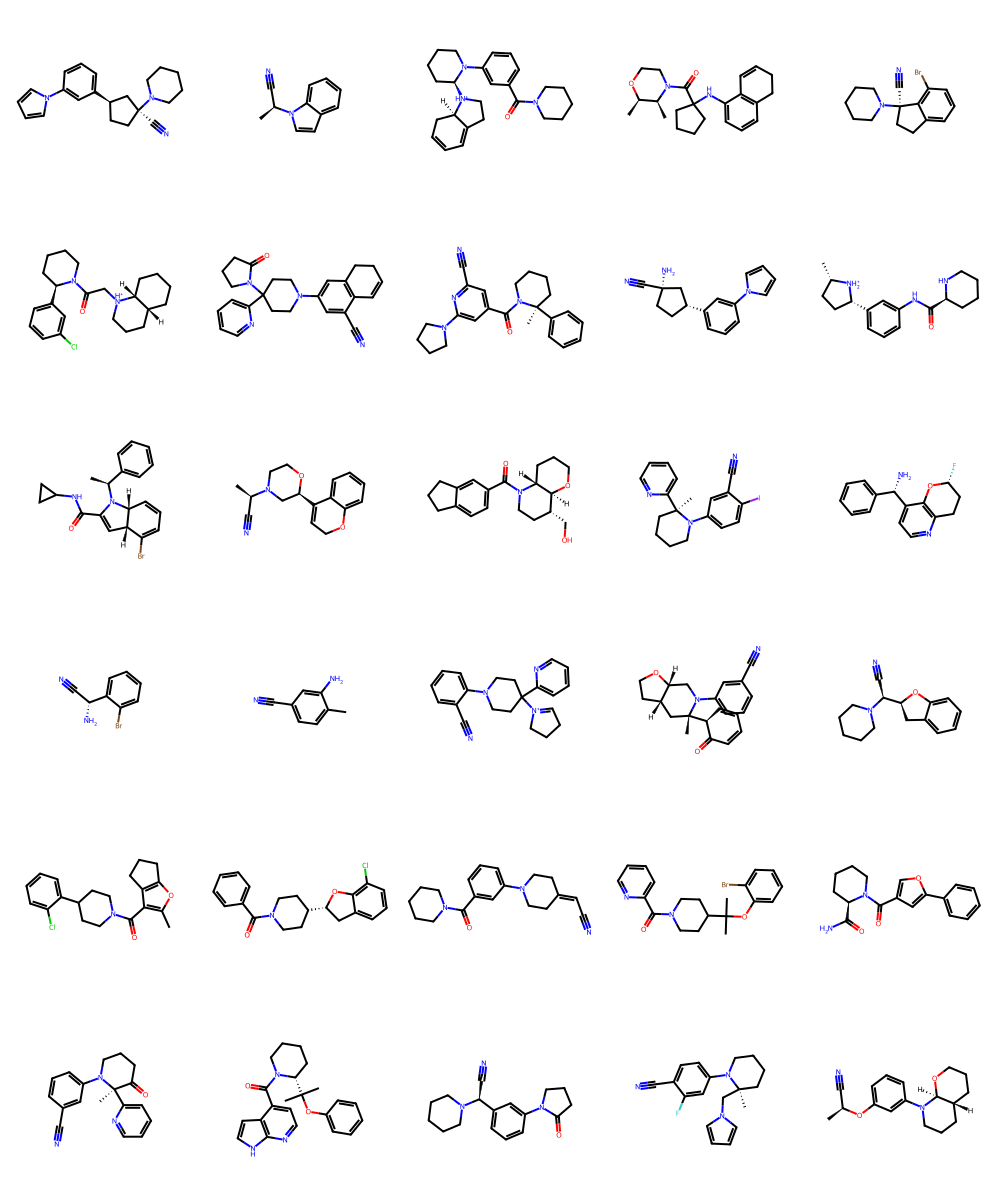

In [53]:
img = rdkit.Chem.Draw.MolsToGridImage([rdkit.Chem.MolFromSmiles(mol) for mol in sorted(diffs,key=diffs.get,reverse=True)[:30]], molsPerRow=5,subImgSize=(200,200))
img

In [54]:
data = pickle.load(open("200pred_list_prob03_doubleexhaustforbest.pk1","rb"))
diffs2 = {}
for entry in data:
    if entry[0]!="failed":
        try:
            max_score=max_affin(entry[0])
            diff = max_score-min(entry[2])
            diffs2[entry[0]]=diff
            print(f"best poss: {max_score:.2f}, best observed: {min(entry[2]):.2f}, diff: {diff:.2f}")
        except:
            print("failed")

max: -9.64, hbonds: -7.5, gauss: -1.47, hydrophob: -0.71
best poss: -9.64, best observed: -5.44, diff: -4.20
max: -6.85, hbonds: -4.6, gauss: -1.41, hydrophob: -0.82
best poss: -6.85, best observed: -5.15, diff: -1.70
max: -7.38, hbonds: -4.8, gauss: -1.59, hydrophob: -0.96
best poss: -7.38, best observed: -6.85, diff: -0.53
max: -5.97, hbonds: -4.0, gauss: -1.23, hydrophob: -0.73
best poss: -5.97, best observed: -5.73, diff: -0.24
max: -7.44, hbonds: -5.5, gauss: -1.25, hydrophob: -0.65
best poss: -7.44, best observed: -5.85, diff: -1.60
max: -6.12, hbonds: -4.3, gauss: -1.19, hydrophob: -0.67
best poss: -6.12, best observed: -5.94, diff: -0.18
max: -9.39, hbonds: -6.5, gauss: -1.82, hydrophob: -1.04
best poss: -9.39, best observed: -7.51, diff: -1.88
max: -9.02, hbonds: -7.0, gauss: -1.35, hydrophob: -0.64
best poss: -9.02, best observed: -6.05, diff: -2.97
max: -6.95, hbonds: -4.5, gauss: -1.53, hydrophob: -0.93
best poss: -6.95, best observed: -7.62, diff: 0.67
max: -9.13, hbonds: 

In [58]:
for mol in sorted(diffs2,key=diffs2.get,reverse=True)[:30]:
    print(mol,diffs2[mol])
    max_affin(mol)

CCN(C=O)c1ccc2ccn(C[C@@H](CO)c3ccccc3)c2c1 1.5416594577100637
max: -5.87, hbonds: -3.2, gauss: -1.59, hydrophob: -1.05
Cc1ccc(Cl)c(NC(=O)c2cccn2C[C@@H](C)c2ccccc2)c1 1.4375855441638494
max: -6.65, hbonds: -3.9, gauss: -1.65, hydrophob: -1.05
Cc1oc(NC(=O)Cc2ccccc2-n2cccn2)c2c1CC=CC2 1.357310931209038
max: -6.77, hbonds: -4.2, gauss: -1.61, hydrophob: -1.01
Cc1ccc(NC(=O)c2cccn2Cc2ccc(Cl)cc2)cc1 1.2060849826681679
max: -6.58, hbonds: -4.1, gauss: -1.53, hydrophob: -0.95
Cc1ccccc1NC(=O)c1[nH]ccc1-c1ccccc1Cl 1.1315386410318995
max: -6.97, hbonds: -4.7, gauss: -1.45, hydrophob: -0.85
Cc1cc(NC(=O)Cc2ccccc2-n2cccc2)co1 1.0591193295826073
max: -5.28, hbonds: -3.0, gauss: -1.37, hydrophob: -0.89
CCN(C(=O)c1ccccc1NCc1cc(C)c[nH]1)[C@H]1CCCS1 0.9059300563354356
max: -6.78, hbonds: -4.2, gauss: -1.60, hydrophob: -1.00
Cc1cocc1NC(=O)Cc1ccn(-c2ccccc2)n1 0.8161607577473537
max: -6.39, hbonds: -4.2, gauss: -1.38, hydrophob: -0.83
Cc1cccc(-n2cc3ccoc3c2C(=O)NCc2ccc(Cl)cc2)c1 0.8008719140355955
max: -7.55,

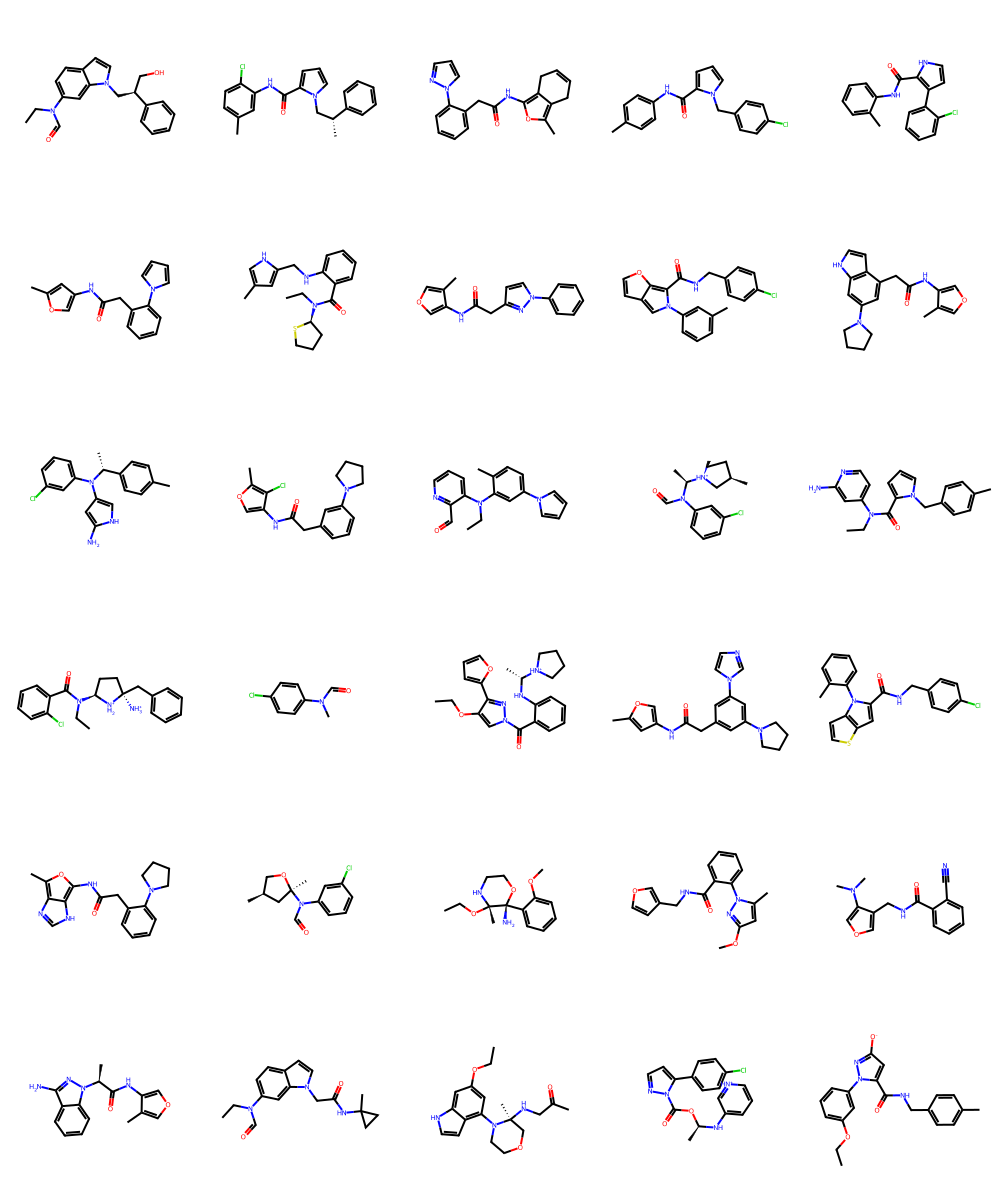

In [57]:
img = rdkit.Chem.Draw.MolsToGridImage([rdkit.Chem.MolFromSmiles(mol) for mol in sorted(diffs2,key=diffs2.get,reverse=True)[:30]], molsPerRow=5,subImgSize=(200,200))
img

/home/azureuser/.local/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


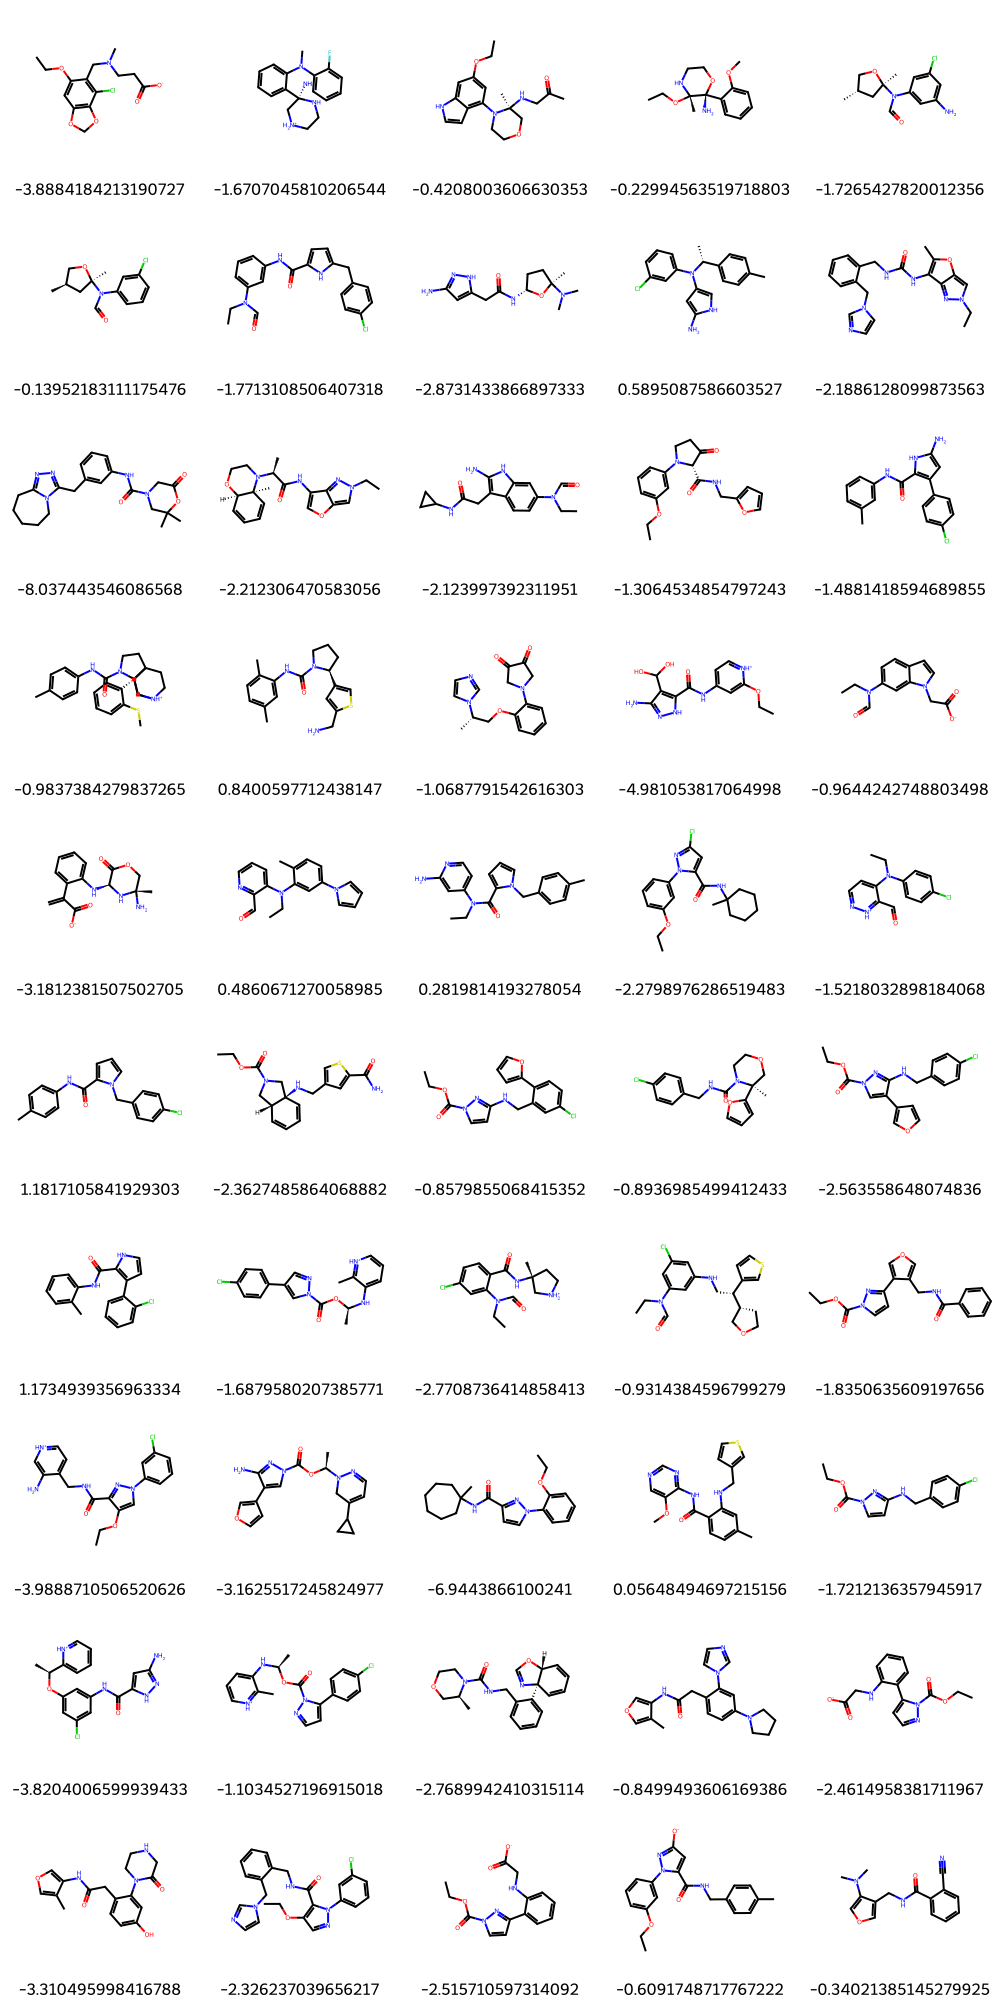

In [49]:
img = rdkit.Chem.Draw.MolsToGridImage([rdkit.Chem.MolFromSmiles(mol) for mol in diffs2], molsPerRow=5,subImgSize=(200,200),legends = [str(diffs2[i]) for i in diffs2])
img